# Cross-validation with Chronos

Peixero github: https://github.com/marcopeix/TimeSeriesForecastingUsingFoundationModels/blob/main/CH05/CH05.ipynb

Chronos github: https://github.com/amazon-science/chronos-forecasting/tree/mlx

In [1]:
# Packages
import numpy as np
from chronos_mlx import ChronosPipeline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import yfinance as yf

### Functions

In [2]:
# Load the Chronos pipeline (MLX version for Apple Silicon)
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",  # other sizes: chronos-t5-mini, -base, -large
    dtype="bfloat16",           # required for MLX
)

In [3]:
# Chronos forecast function using sequential index (no dates)
def forecast_chronos(series, pipeline, context_length=66, prediction_days=22,
                     n_samples=100, temperature=1.0, top_k=50, top_p=1.0):
    """
    Forecast future paths from a simulated series using Chronos (MLX version).

    Parameters:
    - series: pd.Series, the simulated price series
    - pipeline: ChronosPipeline (MLX)
    - context_length: number of past points to condition on
    - prediction_days: number of steps ahead to forecast
    - n_samples: number of trajectories to sample
    - temperature, top_k, top_p: sampling controls

    Returns:
    - low, median, high: 10-50-90 percentiles (np.ndarrays)
    - samples: all forecast paths
    - base_price: last actual value used for forecasting
    """
    context_array = series[-context_length:].values

    forecasts = pipeline.predict(
        context=context_array,
        prediction_length=prediction_days,
        num_samples=n_samples,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
    )

    samples = forecasts[0]  # shape: [n_samples, prediction_days]
    low, median, high = np.quantile(samples, [0.1, 0.5, 0.9], axis=0)

    return low, median, high, samples, context_array[-1]

In [4]:
# Cross-validation function for Chronos
def chronos_cv_min(
    series: pd.Series,
    forecaster_function,
    pipeline,
    context_length: int,
    prediction_days: int,
    number_windows: int,
    number_samples: int = 100,
    sampling_kwargs: dict | None = None,
):
    """
    Rolling-block cross-validation for Chronos/TSFM forecasters.

    Parameters
    ----------
    series : pd.Series
        Univariate series (DatetimeIndex or RangeIndex).
    forecaster_function : callable
        Returns (low, median, high, samples, base_value) given
        (series, pipeline, context_length, prediction_days, n_samples, **kwargs).
    pipeline : object
        Loaded Chronos pipeline (MLX or other backend).
    context_length : int
        Past points used as model context before each forecast.
    prediction_days : int
        Forecast horizon per window.
    number_windows : int
        How many non-overlapping forecast windows to evaluate (step = prediction_days).
    number_samples : int
        Number of sampled forecast paths per window.
    sampling_kwargs : dict, optional
        Extra kwargs passed to forecaster_function (e.g., temperature, top_k, top_p).

    Returns
    -------
    evaluation_dataframe : pd.DataFrame
        Columns ["true","low","median","high"] over the concatenated CV evaluation span.
    metrics : dict
        {
          "overall_mse", "overall_rmse", "overall_mae",
          "overall_mape", "overall_smape", "coverage",
          "window_mse": List[float]  # per-window MSEs
        }
    """
    if sampling_kwargs is None:
        sampling_kwargs = {}

    need = context_length + number_windows * prediction_days
    if len(series) < need:
        raise ValueError(f"Series too short (need {need}, have {len(series)})")

    lows_all, meds_all, highs_all, trues_all = [], [], [], []
    window_mse = []

    for i in range(number_windows, 0, -1):
        history_end = -(prediction_days * i)
        history_series = series.iloc[:history_end]

        low, median, high, samples, _ = forecaster_function(
            series=history_series,
            pipeline=pipeline,
            context_length=context_length,
            prediction_days=prediction_days,
            n_samples=number_samples,
            **sampling_kwargs,
        )

        true_start = -(prediction_days * i)
        true_end = -(prediction_days * (i - 1)) if (i - 1) > 0 else None
        true_block = series.iloc[true_start:true_end].to_numpy()

        low = np.asarray(low, dtype=float).reshape(-1)
        median = np.asarray(median, dtype=float).reshape(-1)
        high = np.asarray(high, dtype=float).reshape(-1)
        true_block = np.asarray(true_block, dtype=float).reshape(-1)

        window_mse.append(float(np.mean((true_block - median) ** 2)))

        lows_all.append(low)
        meds_all.append(median)
        highs_all.append(high)
        trues_all.append(true_block)

    lows = np.concatenate(lows_all).reshape(-1)
    meds = np.concatenate(meds_all).reshape(-1)
    highs = np.concatenate(highs_all).reshape(-1)
    trues = np.concatenate(trues_all).reshape(-1)

    eval_index = series.index[-(number_windows * prediction_days):]
    evaluation_dataframe = pd.DataFrame(
        {"true": trues, "low": lows, "median": meds, "high": highs},
        index=eval_index,
    )

    mse = float(np.mean((trues - meds) ** 2))
    rmse = float(np.sqrt(mse))
    mae = float(np.mean(np.abs(trues - meds)))
    mape = float(np.mean(np.abs((trues - meds) / trues))) * 100.0
    smape = float(np.mean(2.0 * np.abs(trues - meds) / (np.abs(trues) + np.abs(meds)))) * 100.0
    coverage = float(np.mean((trues >= lows) & (trues <= highs))) * 100.0

    metrics = {
        "overall_mse": mse,
        "overall_rmse": rmse,
        "overall_mae": mae,
        "overall_mape": mape,
        "overall_smape": smape,
        "coverage": coverage,
        "window_mse": window_mse,
    }
    return evaluation_dataframe, metrics

In [5]:
# Plot Forecast and CV
def plot_forecast_eval(series: pd.Series, eval_df: pd.DataFrame, title: str):
    """
    Plot entire true series in black; overlay forecast median (gray dashed, alpha=0.6)
    with a black dot at forecast start and a black connector to the last actual.
    CI shown as light grey fill. No grid.
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    # Actual series
    ax.plot(series.index, series.values, color="black", lw=1.25, label="Actual")

    # Forecast median
    ax.plot(eval_df.index, eval_df["median"].values, ls="--", color="gray", alpha=0.6, lw=2.0, label="Median forecast")

    # Confidence interval
    ax.fill_between(
        eval_df.index,
        eval_df["low"].values,
        eval_df["high"].values,
        color="gray",
        alpha=0.15,
        label="10–90% CI",
    )

    # Black dot at forecast start + connector
    first_eval_date = eval_df.index[0]
    prev_date = series.index[series.index.get_loc(first_eval_date) - 1]
    first_median = float(eval_df["median"].iloc[0])
    last_actual = series.loc[prev_date].item()

    ax.plot(first_eval_date, first_median, marker="o", color="black", ms=6)
    ax.plot([prev_date, first_eval_date], [last_actual, first_median], color="black", lw=1.25)

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Index level")
    ax.legend()
    ax.grid(False)
    plt.tight_layout()
    plt.show()

In [6]:
# Plot for returns (same look, different y-label) 
def plot_forecast_eval_returns(series_ret: pd.Series, eval_df: pd.DataFrame, title: str):
    """
    Plot entire returns series in black; overlay forecast median (gray dashed, alpha=0.6)
    with a black dot at forecast start and a black connector to the last actual return.
    CI shown as light grey fill. No grid.
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    # Actual returns (full 5y)
    ax.plot(series_ret.index, series_ret.values, color="black", lw=1.25, label="Actual (returns)")

    # Forecast median (on returns)
    ax.plot(eval_df.index, eval_df["median"].values, ls="--", color="gray", alpha=0.6, lw=2.0, label="Median forecast")

    # Confidence band
    ax.fill_between(
        eval_df.index,
        eval_df["low"].values,
        eval_df["high"].values,
        color="gray",
        alpha=0.15,
        label="10–90% CI",
    )

    # Black dot at forecast start + connector from last actual return
    first_eval_date = eval_df.index[0]
    prev_date = series_ret.index[series_ret.index.get_loc(first_eval_date) - 1]
    first_median = float(eval_df["median"].iloc[0])
    last_actual  = series_ret.loc[prev_date].item()  # scalar, avoids FutureWarning

    ax.plot(first_eval_date, first_median, marker="o", color="black", ms=6)
    ax.plot([prev_date, first_eval_date], [last_actual, first_median], color="black", lw=1.25)

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Daily return (%)")
    ax.legend()
    ax.grid(False)
    plt.tight_layout()
    plt.show()

In [7]:
def print_metrics(metrics: dict, title: str = "Metrics"):
    """
    Pretty-print overall metrics and per-window MSE summary.
    """
    window_mse = metrics.get("window_mse", [])
    mean_mse = float(np.mean(window_mse)) if window_mse else np.nan
    std_mse = float(np.std(window_mse)) if window_mse else np.nan

    print(f"{title}")
    print("-" * len(title))
    print(f"Overall MSE   : {metrics['overall_mse']:.4f}")
    print(f"Overall RMSE  : {metrics['overall_rmse']:.4f}")
    print(f"Overall MAE   : {metrics['overall_mae']:.4f}")
    print(f"Overall MAPE% : {metrics['overall_mape']:.4f}")
    print(f"Overall sMAPE%: {metrics['overall_smape']:.4f}")
    print(f"Coverage %    : {metrics['coverage']:.2f}")
    print(f"Window MSE μ  : {mean_mse:.4f}")
    print(f"Window MSE σ  : {std_mse:.4f}")

---

### Experiment 1 on SP&500 Prices

In [8]:
# Full S&P 500 (1960-2025)
sp500_full = yf.download("^GSPC",
                         start="1960-01-01",
                         end="2025-12-31",
                         interval="1d",
                         auto_adjust=True,
                         progress=False)["Close"].dropna()
sp500_full.name = "sp500_close_full"

# Last 5 years (for plotting & CV input)
last_5y_start = sp500_full.index.max() - pd.DateOffset(years=5)
sp500_last5y = sp500_full.loc[last_5y_start:].copy()
sp500_last5y.name = "sp500_close_last5y"

In [9]:
# CV params 
context_length  = 66
prediction_days = 22
number_windows  = 12  # ~1 trading year

In [10]:
# Run CV
eval_df, metrics = chronos_cv_min(
    series=sp500_last5y,
    forecaster_function=forecast_chronos,
    pipeline=pipeline,
    context_length=context_length,
    prediction_days=prediction_days,
    number_windows=number_windows,
    number_samples=100,
    sampling_kwargs={"temperature": 1.0, "top_k": 50, "top_p": 1.0},
)

In [11]:
# Print metrics
print_metrics(metrics, title="Chronos CV — Last 1 Year (within Last 5Y)")

Chronos CV — Last 1 Year (within Last 5Y)
-----------------------------------------
Overall MSE   : 225772.9487
Overall RMSE  : 475.1557
Overall MAE   : 406.1160
Overall MAPE% : 6.9429
Overall sMAPE%: 7.1226
Coverage %    : 96.21
Window MSE μ  : 225772.9487
Window MSE σ  : 269345.2143


In [12]:
# Per-window MSE
eval_dates = eval_df.index.to_list()
per_window = metrics["window_mse"]
print("\nPer-window MSEs:")
for j, mse in enumerate(per_window, start=1):
    start_idx = (j - 1) * prediction_days
    end_idx   = min(j * prediction_days - 1, len(eval_dates) - 1)
    start_dt  = pd.Timestamp(eval_dates[start_idx]).date()
    end_dt    = pd.Timestamp(eval_dates[end_idx]).date()
    print(f"  Window {j:02d}: {start_dt} → {end_dt} | MSE: {mse:.4f}")


Per-window MSEs:
  Window 01: 2024-07-22 → 2024-08-20 | MSE: 189716.0181
  Window 02: 2024-08-21 → 2024-09-20 | MSE: 119838.3129
  Window 03: 2024-09-23 → 2024-10-22 | MSE: 116332.0285
  Window 04: 2024-10-23 → 2024-11-21 | MSE: 163804.6318
  Window 05: 2024-11-22 → 2024-12-24 | MSE: 170658.3987
  Window 06: 2024-12-26 → 2025-01-29 | MSE: 100014.8210
  Window 07: 2025-01-30 → 2025-03-03 | MSE: 75988.3789
  Window 08: 2025-03-04 → 2025-04-02 | MSE: 54186.6087
  Window 09: 2025-04-03 → 2025-05-05 | MSE: 490204.7137
  Window 10: 2025-05-06 → 2025-06-05 | MSE: 21920.4714
  Window 11: 2025-06-06 → 2025-07-09 | MSE: 170321.1812
  Window 12: 2025-07-10 → 2025-08-08 | MSE: 1036289.8194


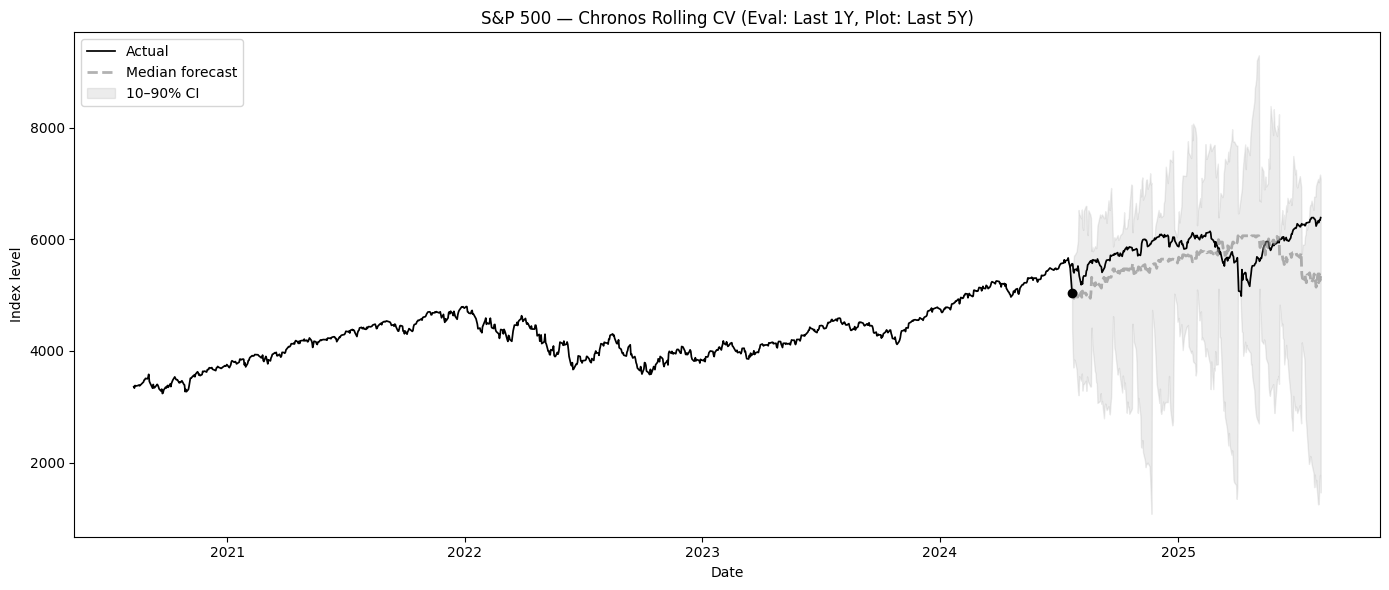

In [13]:
plot_forecast_eval(sp500_last5y, eval_df, "S&P 500 — Chronos Rolling CV (Eval: Last 1Y, Plot: Last 5Y)")

In [17]:
eval_df.head(-5)

,true,low,median,high
Date,,,,
2024-07-22,5564.410156,4407.022057,5036.596637,5443.968424
2024-07-23,5555.740234,4021.870550,5073.630436,5492.112362
2024-07-24,5427.129883,3703.379880,5036.596637,5595.806999
2024-07-25,5399.220215,3844.108315,4944.012140,5710.611775
2024-07-26,5459.100098,3840.404936,5073.630436,5718.018535
...,...,...,...,...
2025-07-28,6389.770020,1812.027983,5301.566588,6528.048411
2025-07-29,6370.859863,1558.818833,5380.694448,6765.431989
2025-07-30,6362.899902,1784.333232,5262.002658,6761.475596


---

### Experiment 2 on SP&500 Returns

In [79]:
# Convert to daily log returns in percent
sp500_last5y_ret = (np.log(sp500_last5y).diff() * 100.0).dropna()
sp500_last5y_ret.name = "sp500_return_last5y_pct"

In [80]:
# Run CV on RETURNS
eval_df_ret, metrics_ret = chronos_cv_min(
    series=sp500_last5y_ret,
    forecaster_function=forecast_chronos,
    pipeline=pipeline,
    context_length=context_length,
    prediction_days=prediction_days,
    number_windows=number_windows,
    number_samples=100,
    sampling_kwargs={"temperature": 1.0, "top_k": 50, "top_p": 1.0},
)

In [81]:
# Print metrics
print_metrics(metrics_ret, title="Chronos CV — Last 1 Year (within Last 5Y) — RETURNS (log %, daily)")

Chronos CV — Last 1 Year (within Last 5Y) — RETURNS (log %, daily)
------------------------------------------------------------------
Overall MSE   : 1.6252
Overall RMSE  : 1.2748
Overall MAE   : 0.8519
Overall MAPE% : 701.8957
Overall sMAPE%: 149.9623
Coverage %    : 20.83
Window MSE μ  : 1.6252
Window MSE σ  : 2.1895


In [82]:
# Per-window MSEs with date spans
eval_dates = eval_df_ret.index.to_list()
per_window = metrics_ret["window_mse"]
print("\nPer-window MSEs (returns):")
for j, mse in enumerate(per_window, start=1):
    start_idx = (j - 1) * prediction_days
    end_idx   = min(j * prediction_days - 1, len(eval_dates) - 1)
    start_dt  = pd.Timestamp(eval_dates[start_idx]).date()
    end_dt    = pd.Timestamp(eval_dates[end_idx]).date()
    print(f"  Window {j:02d}: {start_dt} → {end_dt} | MSE: {mse:.6f}")


Per-window MSEs (returns):
  Window 01: 2024-07-22 → 2024-08-20 | MSE: 1.769927
  Window 02: 2024-08-21 → 2024-09-20 | MSE: 0.812042
  Window 03: 2024-09-23 → 2024-10-22 | MSE: 0.303719
  Window 04: 2024-10-23 → 2024-11-21 | MSE: 1.731241
  Window 05: 2024-11-22 → 2024-12-24 | MSE: 0.807093
  Window 06: 2024-12-26 → 2025-01-29 | MSE: 0.862795
  Window 07: 2025-01-30 → 2025-03-03 | MSE: 0.794519
  Window 08: 2025-03-04 → 2025-04-02 | MSE: 1.719104
  Window 09: 2025-04-03 → 2025-05-05 | MSE: 8.708825
  Window 10: 2025-05-06 → 2025-06-05 | MSE: 1.003759
  Window 11: 2025-06-06 → 2025-07-09 | MSE: 0.394678
  Window 12: 2025-07-10 → 2025-08-08 | MSE: 0.594868


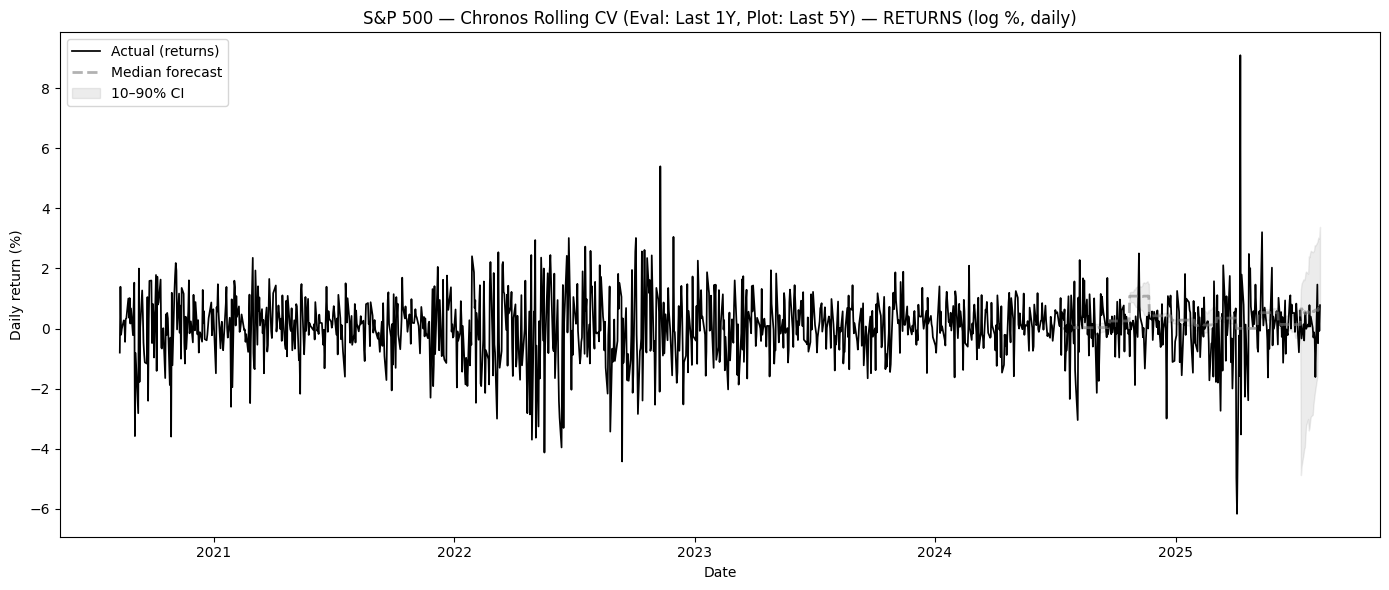

In [83]:
plot_forecast_eval_returns(sp500_last5y_ret, eval_df_ret,
                           "S&P 500 — Chronos Rolling CV (Eval: Last 1Y, Plot: Last 5Y) — RETURNS (log %, daily)")